In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from monty.serialization import dumpfn, loadfn
from collections import defaultdict

In [3]:
from ase.filters import FrechetCellFilter
from ase.optimize import LBFGS
from pymatgen.io.ase import AseAtomsAdaptor
# from orb_models.forcefield import pretrained
# from orb_models.forcefield.calculator import ORBCalculator
from fairchem.core import pretrained_mlip, FAIRChemCalculator
# from mace.calculators import mace_mp # need e3nn 0.4.4
# from sevenn.calculator import SevenNetCalculator # need e3nn 0.5.0 later change numpy to 1.26.4
# from mattersim.forcefield import MatterSimCalculator

/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [5]:
MODEL = "uma" # "orb" or "uma" or "mace" or "grace" or "seven" or "mattersim" or "eqnorm" or "hienet"

In [6]:
# orb_ff = pretrained.orb_v3_conservative_inf_omat(device="cuda",precision="float32-high")   # or "float32-highest" / "float64
# orb_calc = ORBCalculator(orb_ff, device="cuda")

uma_ff = pretrained_mlip.get_predict_unit("uma-m-1p1", device="cuda")
uma_calc = FAIRChemCalculator(uma_ff, task_name="omat")


# seven_calc = SevenNetCalculator('7net-mf-ompa', modal='omat24')

# mattersim_calc = MatterSimCalculator(device="cuda")

MODELS = {
    # "orb":orb_calc,
    "uma":uma_calc,
    # "MPALOE_MatPES":mace_calc,
    # "seven":seven_calc,
    # "mattersim":mattersim_calc,
}

In [7]:
# Function used to relax initial primitive cell and for competing phase calculation, full relaxation using FrechetCellFilter
def relax_structure(structure):
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(FrechetCellFilter(atoms)) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    structure1 = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return structure1, energy 
    

In [8]:
# Function that relaxes defect and pristine supercells, ensuring a fixed lattice by no FrechetCellFilter
def relax_defect(structure): # takes in pymatgen structure
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(atoms) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    structure1 = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return structure1, energy 

## Relaxation of Primitive Al Cells

In [9]:
matching_pairs = loadfn('../data/matching_AlCr_ox.json')

In [10]:
relaxed_Al_prim = {}
for name, val in matching_pairs.items():
    structure, energy = relax_structure(val['structure'])
    relaxed_Al_prim[name] = {
        'formula': val['formula'],
        'energy': energy,
        'structure': structure
    }

       Step     Time          Energy          fmax
LBFGS:    0 18:21:02     -380.434084        0.808930
LBFGS:    1 18:21:03     -380.590289        0.524302


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.719861941977749e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    2 18:21:04     -380.685107        0.379665


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.72735915189905e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 18:21:04     -380.725905        0.335460


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.699138365346192e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    4 18:21:05     -380.755026        0.294177


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.722232076809331e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    5 18:21:05     -380.778330        0.275428


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.710200744117937e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    6 18:21:06     -380.796629        0.261811


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.670745386636728e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    7 18:21:06     -380.817923        0.245291


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.693065004344432e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    8 18:21:07     -380.838694        0.218156


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.73944673534396e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    9 18:21:07     -380.854304        0.191695


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.716604562897957e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   10 18:21:08     -380.866461        0.170804


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.772820178776848e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   11 18:21:08     -380.881087        0.178419


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.745461096372504e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   12 18:21:09     -380.901804        0.249436


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.79637501745152e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   13 18:21:09     -380.926123        0.255327


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.74446617165524e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   14 18:21:10     -380.946440        0.237479


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.758966122635399e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   15 18:21:10     -380.960696        0.164298


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.81489577799954e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   16 18:21:11     -380.973162        0.199216


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.860401493479272e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   17 18:21:12     -380.987223        0.184970


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.836411361145022e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   18 18:21:12     -380.999125        0.135305


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.840252239737918e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   19 18:21:13     -381.005831        0.120782


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.774508254092228e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   20 18:21:13     -381.009917        0.109466


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.822491081081718e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   21 18:21:14     -381.014429        0.104085


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.824790747304548e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   22 18:21:14     -381.020998        0.114668


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.830382806773904e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   23 18:21:15     -381.029120        0.120619


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.82323222524013e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   24 18:21:15     -381.036932        0.101233


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.888237286083105e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   25 18:21:16     -381.042071        0.086108


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.837875194744611e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   26 18:21:17     -381.045111        0.087596


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.88109566851854e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   27 18:21:17     -381.047633        0.102801


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.856686017887404e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   28 18:21:18     -381.050425        0.074139


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.874627786637491e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   29 18:21:18     -381.053431        0.072122


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.902147805266626e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   30 18:21:19     -381.055437        0.060956


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.897590711105397e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   31 18:21:19     -381.056860        0.075053


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.849888369414869e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   32 18:21:20     -381.058348        0.066615


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.841402493108775e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   33 18:21:20     -381.059939        0.058382


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.86694697804671e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   34 18:21:21     -381.061106        0.032941


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.850080043182878e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   35 18:21:22     -381.061880        0.037441


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.855445432134513e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   36 18:21:22     -381.062731        0.043859


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.8349391504166e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   37 18:21:23     -381.063757        0.049786


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.978047433559932e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   38 18:21:23     -381.064707        0.039077


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.897921724590801e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   39 18:21:24     -381.065291        0.026128


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.858992421423685e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   40 18:21:24     -381.065619        0.021988


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.885153666391304e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   41 18:21:25     -381.065958        0.023736


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.843784686098498e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   42 18:21:25     -381.066241        0.023668


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.890152584670647e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   43 18:21:26     -381.066424        0.018791


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.870646131323769e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   44 18:21:26     -381.066576        0.016960


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.815075523111006e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   45 18:21:27     -381.066725        0.017275


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.843460440570421e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   46 18:21:27     -381.066912        0.017645


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.843473709706303e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   47 18:21:28     -381.067049        0.017444


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.845134780864503e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   48 18:21:28     -381.067156        0.017853


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.866841747636178e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   49 18:21:29     -381.067267        0.018336


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.85685905059477e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   50 18:21:30     -381.067404        0.018209


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.897745943893458e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   51 18:21:30     -381.067572        0.018740


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.887779341267877e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   52 18:21:31     -381.067736        0.016332


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.823335472761635e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   53 18:21:31     -381.067908        0.016767


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.861408422501136e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   54 18:21:32     -381.068079        0.017791


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.866431046555187e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   55 18:21:32     -381.068217        0.016692


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.943892311407359e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   56 18:21:33     -381.068320        0.013857


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.863480671908758e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   57 18:21:33     -381.068392        0.013220


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.894770090988423e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   58 18:21:34     -381.068507        0.017694


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.927519099859855e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   59 18:21:34     -381.068610        0.016022


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.820463949005966e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   60 18:21:35     -381.068713        0.010435


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.926609507098666e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   61 18:21:35     -381.068770        0.010917


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.865569925543429e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   62 18:21:36     -381.068839        0.011539


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.925818139682839e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   63 18:21:36     -381.068926        0.016368


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.869106876211053e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   64 18:21:37     -381.069071        0.018254


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.792629677878196e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   65 18:21:37     -381.069209        0.019479


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.828457598766065e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   66 18:21:38     -381.069342        0.015229


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.876911304843743e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   67 18:21:38     -381.069411        0.011586


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.867665058081052e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   68 18:21:39     -381.069468        0.007471
       Step     Time          Energy          fmax
LBFGS:    0 18:21:39      -26.444063        0.385960
LBFGS:    1 18:21:40      -26.451408        0.316380
LBFGS:    2 18:21:40      -26.463084        0.203184
LBFGS:    3 18:21:41      -26.465173        0.219246
LBFGS:    4 18:21:41      -26.470321        0.130700
LBFGS:    5 18:21:41      -26.471066        0.041676
LBFGS:    6 18:21:42      -26.471208        0.043584
LBFGS:    7 18:21:42      -26.471284        0.045535
LBFGS:    8 18:21:43      -26.471447        0.040162
LBFGS:    9 18:21:43      -26.471588        0.030712
LBFGS:   10 18:21:43      -26.471654        0.012513
LBFGS:   11 18:21:44      -26.471662        0.001899
       Step     Time          Energy          fmax
LBFGS:    0 18:21:44      -35.136176        0.418707
LBFGS:    1 18:21:44      -35.143677        0.370641
LBFGS:    2 18:21:45      -35.164570        0.099608
LBFGS:    3 18:21:45      -35.165521        0.0928

/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.284645283036464e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    1 18:22:13     -311.060609        0.014720


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.367854723288505e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    2 18:22:14     -311.060663        0.013446


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3677987280644756e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 18:22:14     -311.060708        0.012411


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.332923738956411e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    4 18:22:15     -311.060739        0.011652


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.373274045578751e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    5 18:22:15     -311.060811        0.013962


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.342564611523615e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    6 18:22:16     -311.060926        0.022656


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3486574820547194e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    7 18:22:16     -311.061033        0.021807


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3654977418482526e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    8 18:22:17     -311.061155        0.016607


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.371710640922237e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    9 18:22:17     -311.061239        0.014261


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.321997071686488e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   10 18:22:18     -311.061330        0.015107


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3285606123459926e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   11 18:22:19     -311.061437        0.021196


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.31486292252905e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   12 18:22:19     -311.061521        0.017830


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3615075023904683e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   13 18:22:20     -311.061597        0.014290


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3723614367446643e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   14 18:22:20     -311.061689        0.014608


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3222703478049777e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   15 18:22:21     -311.061754        0.014412


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3768593079725046e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   16 18:22:21     -311.061815        0.011324


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.357213331272235e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   17 18:22:22     -311.061876        0.011543


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.355876888068339e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   18 18:22:22     -311.061906        0.008960
       Step     Time          Energy          fmax
LBFGS:    0 18:22:23     -426.244255        0.038023


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.206309008500078e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    1 18:22:23     -426.244587        0.036861


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.27386878715615e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    2 18:22:24     -426.244931        0.036234


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.203252100729633e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 18:22:25     -426.245526        0.044658


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.250028588610135e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    4 18:22:25     -426.246521        0.059058


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.215312457598316e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    5 18:22:26     -426.247879        0.051904


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.218118071281732e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    6 18:22:27     -426.249195        0.056169


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.20971738393455e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    7 18:22:27     -426.250019        0.059450


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.239134726909634e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    8 18:22:28     -426.250519        0.059348


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.20859926140719e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    9 18:22:28     -426.251046        0.057338


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.281986633887488e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   10 18:22:29     -426.252064        0.053584


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.253734834288926e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   11 18:22:30     -426.253437        0.084406


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.233410147361501e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   12 18:22:30     -426.255024        0.095358


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.226694648546391e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   13 18:22:31     -426.256325        0.069401


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.21330017227351e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   14 18:22:31     -426.257283        0.049388


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.226637486506723e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   15 18:22:32     -426.258053        0.050121


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.231578206522899e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   16 18:22:33     -426.258923        0.057414


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.317003896785891e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   17 18:22:33     -426.260216        0.087643


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.281490973374782e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   18 18:22:34     -426.262204        0.101517


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.31346080621999e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   19 18:22:34     -426.264946        0.087234


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.295866654185246e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   20 18:22:35     -426.267693        0.066939


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.300211604163733e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   21 18:22:36     -426.269467        0.056599


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.41605984436282e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   22 18:22:36     -426.270447        0.046029


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.395447421969797e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   23 18:22:37     -426.271595        0.046511


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.295429373911156e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   24 18:22:37     -426.273919        0.081588


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.32269082691324e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   25 18:22:38     -426.277699        0.112758


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.35111583004745e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   26 18:22:39     -426.282189        0.113871


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.421357226689449e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   27 18:22:39     -426.285210        0.078254


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.370969360178339e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   28 18:22:40     -426.286431        0.046081


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.435397041778839e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   29 18:22:40     -426.286991        0.043894


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.385176569771821e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   30 18:22:41     -426.287590        0.041559


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.415619616827813e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   31 18:22:42     -426.288514        0.042402


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.365697252849248e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   32 18:22:42     -426.289494        0.039374


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.402024192653853e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   33 18:22:43     -426.290192        0.040771


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.441515329702065e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   34 18:22:44     -426.290493        0.028360


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.491529209934971e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   35 18:22:44     -426.290635        0.016921


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.424849077289745e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   36 18:22:45     -426.290802        0.023409


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.461122938271765e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   37 18:22:45     -426.291161        0.032584


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.465237657705001e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   38 18:22:46     -426.291912        0.040984


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.486007115426687e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   39 18:22:47     -426.293106        0.047744


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.424257774197978e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   40 18:22:47     -426.294220        0.039763
LBFGS:   41 18:22:48     -426.294762        0.033420
LBFGS:   42 18:22:48     -426.294960        0.020879
LBFGS:   43 18:22:49     -426.295109        0.020461
LBFGS:   44 18:22:49     -426.295338        0.019828
LBFGS:   45 18:22:50     -426.295727        0.049240
LBFGS:   46 18:22:51     -426.296196        0.076517
LBFGS:   47 18:22:51     -426.296822        0.093795
LBFGS:   48 18:22:52     -426.297642        0.089454
LBFGS:   49 18:22:52     -426.298546        0.060519
LBFGS:   50 18:22:53     -426.299179        0.026176
LBFGS:   51 18:22:54     -426.299412        0.014375
LBFGS:   52 18:22:54     -426.299508        0.014865
LBFGS:   53 18:22:55     -426.299584        0.014890
LBFGS:   54 18:22:55     -426.299733        0.020374
LBFGS:   55 18:22:56     -426.300026        0.030771
LBFGS:   56 18:22:57     -426.300476        0.051360
LBFGS:   57 18:22:57     -426.300984        0.061740
LBFGS:   58 18:22:58     -426.301350        0.

/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.284645283036463e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    1 18:23:35     -212.371906        0.214873


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.352324802395987e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    2 18:23:35     -212.386926        0.210037


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.39632169665985e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 18:23:36     -212.406669        0.094753


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3715891911218554e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    4 18:23:37     -212.409589        0.091127


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3366083587943226e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    5 18:23:37     -212.416526        0.092521


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3570792320624986e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    6 18:23:38     -212.421106        0.103765


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4292816937051096e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    7 18:23:38     -212.423667        0.079781


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3151124408270364e-13
  return f(*arrays, *other_args, **kwargs)


KeyboardInterrupt: 

In [11]:
dumpfn(relaxed_Al_prim, f'../data/{MODEL}/{MODEL}_relaxed_Al_prim.json')

## Defect Creation and Relaxation

Load in all relaxed primitive Al Oxide structures
<br>Loop through all Al oxides 
<br>Create function using doped and shakenbreak for each structure
<br>Create function that loops over unpertubed and all disortions and uses MLIP to calc energies - append structure and energies to data dict
<br>get energy difference from unperturbed for each Al oxide and append to dictionary or list for bar chart - can do this manually in loop 
<br>dumpfn the data dict and list of energy differences, or maybe add energy diff to data dict as 'delta_e' key?
<br>Plot bar chart for all metal oxides and their energy relative to unperturbed

In [29]:
from doped.generation import DefectsGenerator
from shakenbreak.input import Distortions

In [30]:
supercell_size = 10.1

In [31]:
def create_defect(structure):
    defect_gen = DefectsGenerator(structure, extrinsic="Cr", interstitial_gen_kwargs=False, supercell_gen_kwargs={'min_image_distance':supercell_size} ) # set large super cell 25 Angstroms 'supercell_gen_kwargs={'min_image_distance':15}'
    valid_keys = []
    for key in defect_gen.keys():
        if  key[:5] == 'Cr_Al' and key[-1] == '0':
            valid_keys.append(key)
    Dist = Distortions(
        defect_entries = {key: defect_gen[key] for key in valid_keys}, # NO Cr_Al_0 for Al2(SO4)3
        # oxidation_states={} # oxidation states predicted are good for now
    )
    distorted_defects_dict, Dist.distortion_metadata = Dist.apply_distortions()
    unperturbed_structures = {}
    distortions = {}
    for key in valid_keys:
        unperturbed_structures[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['Unperturbed']
        distortions[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['distortions']

    return dict(unperturbed_structures), dict(distortions), defect_gen.bulk_supercell

In [32]:
def get_energy(unperturbed_structures, distortions, supercell):
    data = defaultdict(dict)
    supercell_struct, supercell_e = relax_defect(supercell)
    data['supercell'] = {
        'structure': supercell_struct,
        'energy': supercell_e
    }
    
    for site, unperturbed_structure in unperturbed_structures.items():
        data[site] = defaultdict(dict)
        data[site]['unperturbed'] = defaultdict(dict)
        unperturbed_structure1, unp_energy = relax_defect(unperturbed_structure)
        data[site]['unperturbed'] = {
        'structure':unperturbed_structure1,
        'energy': unp_energy,
        'distortion_amount':'N/A'
        }
        data[site]['distortions'] = defaultdict(dict)
        for key, structure in distortions[site].items():
            structure1, energy = relax_defect(structure)
            if key != 'Rattled':
                distortion_amount = float(key.split("_")[-1].replace("%", "").replace("-", "-"))/100
            else:
                distortion_amount = 0
            data[site]['distortions'][key] = {
                'structure': structure1,
                'energy': energy,
                'distortion_amount': distortion_amount,
                'delta_e': energy - unp_energy
            }
    
    return dict(data)

In [46]:
Al_prim = loadfn(f'../data/{MODEL}/{MODEL}_relaxed_Al_prim.json')
del Al_prim['mp-554152']

In [53]:
Al_prim['mp-4417']['structure'].num_sites

34

In [41]:
data = {}
for key, val in Al_prim.items():
    unperturbed_structures, distortions, supercell = create_defect(val['structure'])
    mini_data = get_energy(unperturbed_structures, distortions, supercell) # add in host supercell relaxation
    data[key] = mini_data


Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [02:19,   1.39s/it]


Vacancies                 Guessed Charges        Conv. Cell Coords    Wyckoff
------------------------  ---------------------  -------------------  ---------
v_Al                      [+1,0,-1,-2,-3]        [0.116,0.637,0.375]  4e
v_P_C1_O1.49              [+1,0,-1,-2,-3,-4,-5]  [0.203,0.664,0.016]  4e
v_P_C1_O1.50O1.60         [+1,0,-1,-2,-3,-4,-5]  [0.145,0.544,0.718]  4e
v_P_C1_O1.50O1.61         [+1,0,-1,-2,-3,-4,-5]  [0.415,0.112,0.213]  4e
v_O_C1_P1.49              [+2,+1,0,-1]           [0.822,0.257,0.090]  4e
v_O_C1_P1.50Al1.90O2.52   [+2,+1,0,-1]           [0.194,0.158,0.148]  4e
v_O_C1_P1.50Al1.90O2.53a  [+2,+1,0,-1]           [0.576,0.114,0.107]  4e
v_O_C1_P1.50Al1.90O2.53b  [+2,+1,0,-1]           [0.165,0.619,0.608]  4e
v_O_C1_P1.50Al1.91        [+2,+1,0,-1]           [0.068,0.655,0.141]  4e
v_O_C1_P1.50Al1.92        [+2,+1,0,-1]           [0.055,0.515,0.335]  4e
v_O_C1_P1.60              [+2,+1,0,-1]           [0.853,0.421,0.100]  4e
v_O_C1_P1.61              [+2,+1,0,-1] 

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   1.57it/s]


       Step     Time          Energy          fmax
LBFGS:    0 11:38:04    -1143.208343        0.007474
       Step     Time          Energy          fmax
LBFGS:    0 11:38:09    -1143.582998        1.965486
LBFGS:    1 11:38:14    -1143.738332        1.312480
LBFGS:    2 11:38:19    -1143.871831        0.596136
LBFGS:    3 11:38:24    -1143.919637        0.378882
LBFGS:    4 11:38:29    -1143.947607        0.303818
LBFGS:    5 11:38:33    -1143.967870        0.176623
LBFGS:    6 11:38:39    -1143.978902        0.213225
LBFGS:    7 11:38:44    -1143.989065        0.194208
LBFGS:    8 11:38:49    -1143.996328        0.100056
LBFGS:    9 11:38:54    -1144.000127        0.103004
LBFGS:   10 11:38:59    -1144.002370        0.068736
LBFGS:   11 11:39:04    -1144.004278        0.079721
LBFGS:   12 11:39:09    -1144.005849        0.065175
LBFGS:   13 11:39:14    -1144.007253        0.053657
LBFGS:   14 11:39:19    -1144.008596        0.055589
LBFGS:   15 11:39:24    -1144.009771        0.0627

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:32,   3.06it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Li         [+1,0,-1]          [0.000,0.000,0.000]  3a
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  3b
v_O          [+2,+1,0,-1]       [0.000,0.000,0.238]  6c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Li_Al            [0,-1,-2]           [0.000,0.000,0.500]  3b
Li_O             [+3,+2,+1,0]        [0.000,0.000,0.238]  6c
Al_Li            [+2,+1,0]           [0.000,0.000,0.000]  3a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c
O_Li             [0,-1,-2,-3]        [0.000,0.000,0.000]  3a
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.500]  3b
Cr_Li            [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.000]  3a
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.500]  3b
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c

The number in the Wycko

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   1.31it/s]


       Step     Time          Energy          fmax
LBFGS:    0 11:47:28     -688.263277        0.001867
       Step     Time          Energy          fmax
LBFGS:    0 11:47:34     -688.903038        1.693452
LBFGS:    1 11:47:40     -689.100182        1.030938
LBFGS:    2 11:47:46     -689.237069        0.216193
LBFGS:    3 11:47:52     -689.245095        0.138489
LBFGS:    4 11:47:57     -689.250283        0.080497
LBFGS:    5 11:48:03     -689.252968        0.060102
LBFGS:    6 11:48:09     -689.254433        0.048848
LBFGS:    7 11:48:15     -689.255074        0.028129
LBFGS:    8 11:48:21     -689.255425        0.020982
LBFGS:    9 11:48:27     -689.255776        0.018547
LBFGS:   10 11:48:33     -689.256051        0.020992
LBFGS:   11 11:48:39     -689.256279        0.013579
LBFGS:   12 11:48:45     -689.256432        0.011445
LBFGS:   13 11:48:51     -689.256462        0.009499
       Step     Time          Energy          fmax
LBFGS:    0 11:49:00     -626.821000       15.396258

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:29,   3.44it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.500,0.000,0.405]  2b
v_Cl         [+1,0,-1]          [0.000,0.000,0.213]  2a
v_O          [+2,+1,0,-1]       [0.000,0.000,0.545]  2a

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.213]  2a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.545]  2a
Cl_Al            [0,-1,-2,-3,-4]     [0.500,0.000,0.405]  2b
Cl_O             [+1,0]              [0.000,0.000,0.545]  2a
O_Al             [0,-1,-2,-3,-4,-5]  [0.500,0.000,0.405]  2b
O_Cl             [0,-1]              [0.000,0.000,0.213]  2a
Cr_Al            [+3,+2,+1,0,-1]     [0.500,0.000,0.405]  2b
Cr_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.213]  2a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.545]  2a

The number in the Wycko

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.09it/s]


       Step     Time          Energy          fmax
LBFGS:    0 11:53:28     -351.988397        0.000592
       Step     Time          Energy          fmax
LBFGS:    0 11:53:31     -353.124848        2.179835
LBFGS:    1 11:53:33     -353.270584        1.064786
LBFGS:    2 11:53:36     -353.347389        0.383142
LBFGS:    3 11:53:38     -353.364006        0.294769
LBFGS:    4 11:53:40     -353.381867        0.189227
LBFGS:    5 11:53:42     -353.386757        0.148433
LBFGS:    6 11:53:45     -353.389847        0.099376
LBFGS:    7 11:53:47     -353.391594        0.094904
LBFGS:    8 11:53:49     -353.393158        0.101088
LBFGS:    9 11:53:52     -353.394089        0.067521
LBFGS:   10 11:53:54     -353.394669        0.035103
LBFGS:   11 11:53:56     -353.395088        0.042211
LBFGS:   12 11:53:58     -353.395546        0.036952
LBFGS:   13 11:54:01     -353.395958        0.037965
LBFGS:   14 11:54:03     -353.396370        0.031337
LBFGS:   15 11:54:05     -353.396721        0.0238

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:41,   2.41it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Sm         [+1,0,-1,-2,-3]    [0.491,0.750,0.036]  4c
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.000]  4a
v_O_C1       [+2,+1,0,-1]       [0.219,0.538,0.282]  8d
v_O_Cs       [+2,+1,0,-1]       [0.072,0.250,0.013]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Sm_Al            [+1,0,-1]           [0.000,0.000,0.000]  4a
Sm_O_C1          [+5,+4,+3,+2,+1,0]  [0.219,0.538,0.282]  8d
Sm_O_Cs          [+5,+4,+3,+2,+1,0]  [0.072,0.250,0.013]  4c
Al_Sm            [+1,0,-1]           [0.491,0.750,0.036]  4c
Al_O_C1          [+5,+4,+3,+2,+1,0]  [0.219,0.538,0.282]  8d
Al_O_Cs          [+5,+4,+3,+2,+1,0]  [0.072,0.250,0.013]  4c
O_Sm             [0,-1,-2,-3,-4,-5]  [0.491,0.750,0.036]  4c
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.000]  4a
Cr_Sm            [+3,+2,+1,0,

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.32it/s]


       Step     Time          Energy          fmax
LBFGS:    0 11:56:45     -634.784229        0.008149
       Step     Time          Energy          fmax
LBFGS:    0 11:56:49     -635.443948        1.687027
LBFGS:    1 11:56:53     -635.618677        0.923087
LBFGS:    2 11:56:57     -635.708734        0.236160
LBFGS:    3 11:57:01     -635.719446        0.166736
LBFGS:    4 11:57:04     -635.732614        0.131197
LBFGS:    5 11:57:08     -635.736490        0.095743
LBFGS:    6 11:57:12     -635.739847        0.068554
LBFGS:    7 11:57:16     -635.741632        0.049313
LBFGS:    8 11:57:20     -635.743417        0.044865
LBFGS:    9 11:57:24     -635.745020        0.048004
LBFGS:   10 11:57:28     -635.746301        0.042849
LBFGS:   11 11:57:32     -635.747034        0.028761
LBFGS:   12 11:57:36     -635.747431        0.023698
LBFGS:   13 11:57:39     -635.747690        0.020611
LBFGS:   14 11:57:43     -635.748026        0.020409
LBFGS:   15 11:57:47     -635.748163        0.0158

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:43,   2.29it/s]


Vacancies       Guessed Charges        Conv. Cell Coords    Wyckoff
--------------  ---------------------  -------------------  ---------
v_Al            [+1,0,-1,-2,-3]        [0.000,0.000,0.000]  2a
v_W             [+1,0,-1,-2,-3,-4,-5]  [0.000,0.500,0.500]  2c
v_O_C2v_Al1.89  [+2,+1,0,-1]           [0.000,0.294,0.000]  4i
v_O_C2v_W1.95   [+2,+1,0,-1]           [0.305,0.500,0.500]  4h

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Al_O_C2v_Al1.89  [+5,+4,+3,+2,+1,0]           [0.000,0.294,0.000]  4i
Al_W             [0,-1,-2]                    [0.000,0.500,0.500]  2c
Al_O_C2v_W1.95   [+5,+4,+3,+2,+1,0]           [0.305,0.500,0.500]  4h
W_Al             [+3,+2,+1,0,-1]              [0.000,0.000,0.000]  2a
W_O_C2v_Al1.89   [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.000,0.294,0.000]  4i
W_O_C2v_W1.95    [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.305,0.500,0.500]  4h
O_Al             [0,-1,-2,-3,-4,-5]  

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   1.59it/s]


       Step     Time          Energy          fmax
LBFGS:    0 12:00:56     -634.132811        0.001249
       Step     Time          Energy          fmax
LBFGS:    0 12:01:00     -635.135197        1.882383
LBFGS:    1 12:01:05     -635.264509        0.936362
LBFGS:    2 12:01:09     -635.360420        0.311136
LBFGS:    3 12:01:13     -635.380047        0.256638
LBFGS:    4 12:01:18     -635.396368        0.211474
LBFGS:    5 12:01:22     -635.402889        0.081698
LBFGS:    6 12:01:26     -635.406327        0.064067
LBFGS:    7 12:01:30     -635.407950        0.068966
LBFGS:    8 12:01:35     -635.409174        0.058948
LBFGS:    9 12:01:39     -635.410059        0.033216
LBFGS:   10 12:01:43     -635.410675        0.028796
LBFGS:   11 12:01:47     -635.411047        0.023216
LBFGS:   12 12:01:51     -635.411289        0.018680
LBFGS:   13 12:01:56     -635.411427        0.014682
LBFGS:   14 12:02:00     -635.411520        0.010967
LBFGS:   15 12:02:04     -635.411579        0.0091

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [02:10,   1.31s/it]


Vacancies                 Guessed Charges        Conv. Cell Coords    Wyckoff
------------------------  ---------------------  -------------------  ---------
v_K_C1_O2.80O2.88O2.92    [+1,0,-1]              [0.319,0.682,0.191]  2a
v_K_C1_O2.80O2.88O2.93    [+1,0,-1]              [0.682,0.318,0.309]  2a
v_Al_C1_O1.87O1.90O1.94   [+1,0,-1,-2,-3]        [0.261,0.400,0.491]  2a
v_Al_C1_O1.87O1.90O1.95   [+1,0,-1,-2,-3]        [0.739,0.600,0.009]  2a
v_P_C1_O1.50O1.53O1.63a   [+1,0,-1,-2,-3,-4,-5]  [0.374,0.098,0.419]  2a
v_P_C1_O1.50O1.53O1.63b   [+1,0,-1,-2,-3,-4,-5]  [0.374,0.403,0.919]  2a
v_P_C1_O1.52O1.64P2.89a   [+1,0,-1,-2,-3,-4,-5]  [0.066,0.369,0.062]  2a
v_P_C1_O1.52O1.64P2.89b   [+1,0,-1,-2,-3,-4,-5]  [0.067,0.131,0.562]  2a
v_O_C1_P1.50Al1.87O2.52a  [+2,+1,0,-1]           [0.350,0.092,0.230]  2a
v_O_C1_P1.50Al1.87O2.52b  [+2,+1,0,-1]           [0.350,0.407,0.730]  2a
v_O_C1_P1.52Al1.90O2.51a  [+2,+1,0,-1]           [0.177,0.396,0.247]  2a
v_O_C1_P1.52Al1.90O2.51b  [+2,+1,0,-1] 

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al_C1_O1.87O1.90O1.94
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.87O1.90O1.94 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...50.0%|██████████████████████████                          | [00:00,   3.49it/s]


Defect: Cr_Al_C1_O1.87O1.90O1.95
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.87O1.90O1.95 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   3.63it/s]


       Step     Time          Energy          fmax
LBFGS:    0 12:06:40     -933.185654        0.008968
       Step     Time          Energy          fmax
LBFGS:    0 12:06:45     -933.707495        1.918703
LBFGS:    1 12:06:50     -933.849585        1.334226
LBFGS:    2 12:06:55     -933.956610        0.456133
LBFGS:    3 12:07:00     -934.008795        0.406664
LBFGS:    4 12:07:05     -934.037024        0.284979
LBFGS:    5 12:07:10     -934.058371        0.211776
LBFGS:    6 12:07:15     -934.070944        0.170151
LBFGS:    7 12:07:19     -934.078421        0.133182
LBFGS:    8 12:07:24     -934.084128        0.122103
LBFGS:    9 12:07:29     -934.089758        0.113735
LBFGS:   10 12:07:34     -934.095007        0.114769
LBFGS:   11 12:07:39     -934.098700        0.096647
LBFGS:   12 12:07:44     -934.101218        0.084851
LBFGS:   13 12:07:49     -934.103415        0.080158
LBFGS:   14 12:07:54     -934.105719        0.080380
LBFGS:   15 12:07:59     -934.107626        0.0689

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:27,   3.61it/s]


Vacancies                Guessed Charges        Conv. Cell Coords    Wyckoff
-----------------------  ---------------------  -------------------  ---------
v_Cs_C2_O3.22            [+1,0,-1]              [0.297,0.297,0.000]  3a
v_Cs_C2_O3.32            [+1,0,-1]              [0.464,0.464,0.500]  3b
v_Al                     [+1,0,-1,-2,-3]        [0.690,0.690,0.000]  3a
v_N_C1_O1.24O1.33Al2.90  [+1,0,-1,-2,-3,-4,-5]  [0.555,0.242,0.245]  6c
v_N_C1_O1.24O1.33Al2.93  [+1,0,-1,-2,-3,-4,-5]  [0.089,0.348,0.405]  6c
v_N_C2                   [+1,0,-1,-2,-3,-4,-5]  [0.904,0.904,0.000]  3a
v_O_C1_N1.24O2.18O2.20   [+2,+1,0,-1]           [0.321,0.614,0.108]  6c
v_O_C1_N1.24O2.18O3.27   [+2,+1,0,-1]           [0.185,0.385,0.330]  6c
v_O_C1_N1.25O2.20O2.23   [+2,+1,0,-1]           [0.335,0.032,0.041]  6c
v_O_C1_N1.25O2.20O2.93   [+2,+1,0,-1]           [0.491,0.305,0.242]  6c
v_O_C1_N1.30             [+2,+1,0,-1]           [0.205,0.090,0.274]  6c
v_O_C1_N1.33Al1.87       [+2,+1,0,-1]           [0.4

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 1.2187558443149134 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:34,  34.51s/it]


       Step     Time          Energy          fmax
LBFGS:    0 12:25:01     -426.325180        0.009357
       Step     Time          Energy          fmax
LBFGS:    0 12:25:04     -427.403140        1.996245
LBFGS:    1 12:25:06     -427.557421        0.810191
LBFGS:    2 12:25:09     -427.649275        0.651996
LBFGS:    3 12:25:11     -427.718985        0.743035
LBFGS:    4 12:25:14     -427.793082        0.800252
LBFGS:    5 12:25:16     -427.843123        0.586334
LBFGS:    6 12:25:18     -427.859454        0.254720
LBFGS:    7 12:25:21     -427.862010        0.119478
LBFGS:    8 12:25:24     -427.862807        0.092726
LBFGS:    9 12:25:27     -427.863742        0.082815
LBFGS:   10 12:25:29     -427.865485        0.118320
LBFGS:   11 12:25:31     -427.867781        0.142595
LBFGS:   12 12:25:34     -427.869746        0.094183
LBFGS:   13 12:25:36     -427.870589        0.052766
LBFGS:   14 12:25:38     -427.870841        0.026436
LBFGS:   15 12:25:41     -427.870948        0.0214

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:34,   1.06it/s]


Vacancies                 Guessed Charges    Conv. Cell Coords    Wyckoff
------------------------  -----------------  -------------------  ---------
v_Al                      [+1,0,-1,-2,-3]    [0.000,0.000,0.250]  6c
v_H_C1_O1.00H1.64Cl2.05a  [+1,0,-1]          [0.184,0.070,0.111]  18f
v_H_C1_O1.00H1.64Cl2.05b  [+1,0,-1]          [0.114,0.184,0.389]  18f
v_H_C1_O1.00H1.64Cl2.06a  [+1,0,-1]          [0.204,0.206,0.165]  18f
v_H_C1_O1.00H1.64Cl2.06b  [+1,0,-1]          [0.206,0.002,0.334]  18f
v_Cl_C2_H2.05O3.05H3.46   [+1,0,-1]          [0.259,0.000,0.000]  9d
v_Cl_C2_H2.05O3.05H3.47   [+1,0,-1]          [0.258,0.258,0.500]  9e
v_O_C1_H1.00Al1.90O2.68a  [+2,+1,0,-1]       [0.151,0.106,0.166]  18f
v_O_C1_H1.00Al1.90O2.68b  [+2,+1,0,-1]       [0.044,0.151,0.334]  18f

Substitutions              Guessed Charges     Conv. Cell Coords    Wyckoff
-------------------------  ------------------  -------------------  ---------
Al_H_C1_O1.00H1.64Cl2.05a  [+2,+1,0]           [0.184,0.070,0.111]  

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 1.000538837225975 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████| [04:37,  277.62s/it]


       Step     Time          Energy          fmax
LBFGS:    0 12:35:51     -425.033534        0.007782
       Step     Time          Energy          fmax
LBFGS:    0 12:35:54     -425.372567        1.715683
LBFGS:    1 12:35:58     -425.532777        0.568034
LBFGS:    2 12:36:02     -425.632097        0.542044
LBFGS:    3 12:36:06     -425.737832        0.334150
LBFGS:    4 12:36:10     -425.765573        0.295738
LBFGS:    5 12:36:14     -425.802495        0.300346
LBFGS:    6 12:36:18     -425.830430        0.260764
LBFGS:    7 12:36:22     -425.845025        0.132077
LBFGS:    8 12:36:26     -425.848569        0.053912
LBFGS:    9 12:36:30     -425.849515        0.049150
LBFGS:   10 12:36:34     -425.850904        0.057512
LBFGS:   11 12:36:38     -425.852815        0.069877
LBFGS:   12 12:36:42     -425.854299        0.048959
LBFGS:   13 12:36:46     -425.854856        0.016161
LBFGS:   14 12:36:50     -425.855008        0.015357
LBFGS:   15 12:36:54     -425.855184        0.0193

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:00,   1.64it/s]


Vacancies     Guessed Charges        Conv. Cell Coords    Wyckoff
------------  ---------------------  -------------------  ---------
v_Na          [+1,0,-1]              [0.044,0.706,0.375]  12d
v_Al          [+1,0,-1,-2,-3]        [0.875,0.875,0.875]  4b
v_P_C1        [+1,0,-1,-2,-3,-4,-5]  [0.146,0.431,0.365]  24e
v_P_C3        [+1,0,-1,-2,-3,-4,-5]  [0.233,0.233,0.233]  8c
v_O_C1_P1.49  [+2,+1,0,-1]           [0.063,0.511,0.323]  24e
v_O_C1_P1.50  [+2,+1,0,-1]           [0.123,0.367,0.468]  24e
v_O_C1_P1.58  [+2,+1,0,-1]           [0.170,0.342,0.266]  24e
v_O_C2        [+2,+1,0,-1]           [0.268,0.482,0.375]  12d
v_O_C3        [+2,+1,0,-1]           [0.162,0.162,0.162]  8c

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Na_Al            [0,-1,-2]                    [0.875,0.875,0.875]  4b
Na_P_C1          [0,-1,-2,-3,-4]              [0.146,0.431,0.365]  24e
Na_P_C3          

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.39it/s]


       Step     Time          Energy          fmax
LBFGS:    0 12:42:10     -972.760113        0.008169
       Step     Time          Energy          fmax
LBFGS:    0 12:42:16     -973.123454        1.703406
LBFGS:    1 12:42:21     -973.274157        1.042017
LBFGS:    2 12:42:26     -973.409014        0.512582
LBFGS:    3 12:42:32     -973.470515        0.343289
LBFGS:    4 12:42:37     -973.500880        0.300647
LBFGS:    5 12:42:42     -973.530749        0.202218
LBFGS:    6 12:42:48     -973.546839        0.120964
LBFGS:    7 12:42:53     -973.557978        0.110722
LBFGS:    8 12:42:59     -973.563746        0.087504
LBFGS:    9 12:43:04     -973.567965        0.086716
LBFGS:   10 12:43:10     -973.572894        0.081193
LBFGS:   11 12:43:15     -973.577647        0.079689
LBFGS:   12 12:43:21     -973.580775        0.055551
LBFGS:   13 12:43:26     -973.582545        0.040194
LBFGS:   14 12:43:32     -973.583750        0.042798
LBFGS:   15 12:43:37     -973.584750        0.0361

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:30,   1.10it/s]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Cs                      [+1,0,-1]                 [0.000,0.000,0.000]  4a
v_Al                      [+1,0,-1,-2,-3]           [0.500,0.500,0.500]  4a
v_H_C1_O0.99H1.56O1.77a   [+1,0,-1]                 [0.227,0.390,0.336]  12b
v_H_C1_O0.99H1.56O1.77b   [+1,0,-1]                 [0.226,0.508,0.308]  12b
v_H_C1_O0.99H1.56O1.77c   [+1,0,-1]                 [0.164,0.727,0.390]  12b
v_H_C1_O1.00H1.56         [+1,0,-1]                 [0.009,0.308,0.275]  12b
v_H_C1_O1.00H1.65O1.70a   [+1,0,-1]                 [0.042,0.083,0.319]  12b
v_H_C1_O1.00H1.65O1.70b   [+1,0,-1]                 [0.084,0.181,0.542]  12b
v_H_C1_O1.02O1.59         [+1,0,-1]                 [0.043,0.801,0.475]  12b
v_H_C1_O1.02O1.60         [+1,0,-1]                 [0.301,0.475,0.457]  12b
v_Se_C3_O1.68H2.92H2.97a  [+1,0,-1,-2,-3,-4,-5,-6]  [0.199,0.199,0.1

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 0.9928829576180047 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually
Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [01:22,  82.91s/it]


       Step     Time          Energy          fmax
LBFGS:    0 12:53:10     -986.646500        0.005847
       Step     Time          Energy          fmax
LBFGS:    0 12:53:18     -986.973700        1.705448
LBFGS:    1 12:53:26     -987.135420        0.538223
LBFGS:    2 12:53:34     -987.233900        0.544889
LBFGS:    3 12:53:42     -987.337294        0.346547
LBFGS:    4 12:53:50     -987.367697        0.281698
LBFGS:    5 12:53:57     -987.396086        0.266268
LBFGS:    6 12:54:05     -987.419585        0.232727
LBFGS:    7 12:54:13     -987.433691        0.138202
LBFGS:    8 12:54:21     -987.438757        0.070849
LBFGS:    9 12:54:29     -987.440893        0.067830
LBFGS:   10 12:54:37     -987.444022        0.100971
LBFGS:   11 12:54:45     -987.448004        0.120352
LBFGS:   12 12:54:53     -987.450934        0.081443
LBFGS:   13 12:55:01     -987.452292        0.042282
LBFGS:   14 12:55:09     -987.453154        0.040146
LBFGS:   15 12:55:17     -987.454397        0.0717

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:25,   1.17it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.148]  12c
v_O          [+2,+1,0,-1]       [0.306,0.306,0.250]  18e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_O             [+5,+4,+3,+2,+1,0]  [0.306,0.306,0.250]  18e
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.148]  12c
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.148]  12c
Cr_O             [+5,+4,+3,+2,+1,0]  [0.306,0.306,0.250]  18e

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 6 formula unit(s) of Al2O3.

Oxidation states were not explicitly set, thus have been guessed as {'Al': 3.0, 'O': -2.0, 'Cr': 3.0}. If this is unreasonable you should manually set oxidation_states
Applying ShakeNBreak... Will apply the fo

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   1.63it/s]


       Step     Time          Energy          fmax
LBFGS:    0 13:08:56     -897.796069        0.009224
       Step     Time          Energy          fmax
LBFGS:    0 13:09:03     -898.323281        2.269423
LBFGS:    1 13:09:09     -898.545113        1.107771
LBFGS:    2 13:09:16     -898.651116        0.299514
LBFGS:    3 13:09:23     -898.669976        0.182035
LBFGS:    4 13:09:29     -898.681710        0.133068
LBFGS:    5 13:09:36     -898.686532        0.078210
LBFGS:    6 13:09:42     -898.689065        0.065261
LBFGS:    7 13:09:49     -898.690301        0.048129
LBFGS:    8 13:09:55     -898.691079        0.025255
LBFGS:    9 13:10:02     -898.691461        0.024744
LBFGS:   10 13:10:09     -898.691613        0.019326
LBFGS:   11 13:10:15     -898.691720        0.012390
LBFGS:   12 13:10:22     -898.691827        0.009367
       Step     Time          Energy          fmax
LBFGS:    0 13:10:32     -802.695939       22.732712
LBFGS:    1 13:10:38     -850.964257        9.594565

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [03:54,   2.34s/it]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Al_C3_O1.89             [+1,0,-1,-2,-3]           [0.000,0.000,0.145]  6c
v_Al_C3_O1.90             [+1,0,-1,-2,-3]           [0.000,0.000,0.351]  6c
v_S                       [+1,0,-1,-2,-3,-4,-5,-6]  [0.378,0.046,0.083]  18f
v_O_C1_S1.47              [+2,+1,0,-1]              [0.014,0.191,0.091]  18f
v_O_C1_S1.48Al1.90O2.38a  [+2,+1,0,-1]              [0.183,0.202,0.193]  18f
v_O_C1_S1.48Al1.90O2.38b  [+2,+1,0,-1]              [0.217,0.148,0.302]  18f
v_O_C1_S1.48Al1.90O2.38c  [+2,+1,0,-1]              [0.066,0.214,0.402]  18f

Substitutions              Guessed Charges              Conv. Cell Coords    Wyckoff
-------------------------  ---------------------------  -------------------  ---------
Al_S                       [0,-1,-2,-3]                 [0.378,0.046,0.083]  18f
Al_O_C1_S1.47              [+5,+4,+3,+2,+1,0]

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al_C3_O1.89
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.89 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...50.0%|██████████████████████████                          | [00:00,   1.09it/s]


Defect: Cr_Al_C3_O1.90
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.90 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:01,   1.17it/s]


       Step     Time          Energy          fmax
LBFGS:    0 13:17:19     -885.849204        0.009273
       Step     Time          Energy          fmax
LBFGS:    0 13:17:24     -886.236225        1.765042
LBFGS:    1 13:17:29     -886.388671        1.117932
LBFGS:    2 13:17:35     -886.497630        0.434310
LBFGS:    3 13:17:40     -886.555818        0.364547
LBFGS:    4 13:17:46     -886.601697        0.313946
LBFGS:    5 13:17:51     -886.635358        0.225630
LBFGS:    6 13:17:57     -886.653036        0.148385
LBFGS:    7 13:18:02     -886.659676        0.114349
LBFGS:    8 13:18:07     -886.664126        0.124915
LBFGS:    9 13:18:13     -886.669575        0.103533
LBFGS:   10 13:18:18     -886.674360        0.110569
LBFGS:   11 13:18:23     -886.677886        0.091245
LBFGS:   12 13:18:29     -886.681176        0.080461
LBFGS:   13 13:18:34     -886.684325        0.088222
LBFGS:   14 13:18:39     -886.687147        0.090152
LBFGS:   15 13:18:45     -886.689336        0.0570

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:10,   1.43it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.125,0.125,0.125]  16c
v_Fe         [+1,0,-1,-2]       [0.500,0.500,0.500]  8b
v_O          [+2,+1,0,-1]       [0.359,0.359,0.359]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Fe            [+1,0]              [0.500,0.500,0.500]  8b
Al_O             [+5,+4,+3,+2,+1,0]  [0.359,0.359,0.359]  32e
Fe_Al            [+1,0,-1,-2]        [0.125,0.125,0.125]  16c
Fe_O             [+5,+4,+3,+2,+1,0]  [0.359,0.359,0.359]  32e
O_Al             [0,-1,-2,-3,-4,-5]  [0.125,0.125,0.125]  16c
O_Fe             [0,-1,-2,-3,-4]     [0.500,0.500,0.500]  8b
Cr_Al            [+3,+2,+1,0,-1]     [0.125,0.125,0.125]  16c
Cr_Fe            [+4,+3,+2,+1,0]     [0.500,0.500,0.500]  8b
Cr_O             [+5,+4,+3,+2,+1,0]  [0.359,0.359,0.359]  32e

The number in t

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   1.64it/s]


       Step     Time          Energy          fmax
LBFGS:    0 13:34:48     -609.861051        0.009682
       Step     Time          Energy          fmax
LBFGS:    0 13:34:52     -610.711444        1.557942
LBFGS:    1 13:34:56     -610.881770        1.029251
LBFGS:    2 13:35:01     -611.046062        0.268835
LBFGS:    3 13:35:05     -611.066440        0.216874
LBFGS:    4 13:35:09     -611.086353        0.214833
LBFGS:    5 13:35:13     -611.094898        0.179086
LBFGS:    6 13:35:19     -611.102580        0.143289
LBFGS:    7 13:35:23     -611.106876        0.162597
LBFGS:    8 13:35:27     -611.112048        0.152674
LBFGS:    9 13:35:31     -611.116664        0.118144
LBFGS:   10 13:35:35     -611.120227        0.075398
LBFGS:   11 13:35:40     -611.122340        0.059898
LBFGS:   12 13:35:44     -611.123584        0.050231
LBFGS:   13 13:35:48     -611.124408        0.056765
LBFGS:   14 13:35:52     -611.125133        0.039203
LBFGS:   15 13:35:56     -611.125491        0.0240

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:14,   1.35it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mg         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.389,0.389,0.389]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mg_Al            [0,-1]              [0.625,0.625,0.625]  16d
Mg_O             [+4,+3,+2,+1,0]     [0.389,0.389,0.389]  32e
Al_Mg            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e
O_Mg             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mg            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e

The number in t

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.50it/s]


       Step     Time          Energy          fmax
LBFGS:    0 13:41:05     -794.586801        0.002873
       Step     Time          Energy          fmax
LBFGS:    0 13:41:10     -795.367095        1.563229
LBFGS:    1 13:41:15     -795.536636        0.986429
LBFGS:    2 13:41:21     -795.678573        0.242540
LBFGS:    3 13:41:26     -795.695800        0.187928
LBFGS:    4 13:41:31     -795.709777        0.171504
LBFGS:    5 13:41:37     -795.715682        0.147868
LBFGS:    6 13:41:42     -795.719238        0.105961
LBFGS:    7 13:41:48     -795.721084        0.105993
LBFGS:    8 13:41:53     -795.722473        0.075356
LBFGS:    9 13:41:59     -795.723342        0.038028
LBFGS:   10 13:42:04     -795.723983        0.023325
LBFGS:   11 13:42:09     -795.724288        0.019924
LBFGS:   12 13:42:15     -795.724563        0.023397
LBFGS:   13 13:42:20     -795.724716        0.016938
LBFGS:   14 13:42:26     -795.724777        0.007962
       Step     Time          Energy          fmax

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:07,   1.47it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mn         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.392,0.392,0.392]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mn_Al            [+1,0,-1]           [0.625,0.625,0.625]  16d
Mn_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
Al_Mn            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
O_Mn             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mn            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e

The number in t

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.30it/s]


       Step     Time          Energy          fmax
LBFGS:    0 13:46:35     -637.992559        0.002540
       Step     Time          Energy          fmax
LBFGS:    0 13:46:40     -638.893886        1.511544
LBFGS:    1 13:46:44     -639.055172        0.993409
LBFGS:    2 13:46:48     -639.209179        0.257966
LBFGS:    3 13:46:52     -639.228611        0.212619
LBFGS:    4 13:46:57     -639.245060        0.192319
LBFGS:    5 13:47:01     -639.253071        0.162470
LBFGS:    6 13:47:05     -639.258869        0.131836
LBFGS:    7 13:47:09     -639.262493        0.138899
LBFGS:    8 13:47:13     -639.265621        0.114248
LBFGS:    9 13:47:17     -639.267879        0.066587
LBFGS:   10 13:47:22     -639.269375        0.035136
LBFGS:   11 13:47:26     -639.270275        0.028550
LBFGS:   12 13:47:30     -639.270794        0.033964
LBFGS:   13 13:47:34     -639.271168        0.033374
LBFGS:   14 13:47:38     -639.271419        0.017052
LBFGS:   15 13:47:43     -639.271549        0.0123

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:40,   1.00s/it]


Vacancies            Guessed Charges           Conv. Cell Coords    Wyckoff
-------------------  ------------------------  -------------------  ---------
v_Al                 [+1,0,-1,-2,-3]           [0.382,0.250,0.033]  8d
v_Mo_C1              [+1,0,-1,-2,-3,-4,-5,-6]  [0.355,0.107,0.386]  8d
v_Mo_C2              [+1,0,-1,-2,-3,-4,-5,-6]  [0.000,0.027,0.250]  4c
v_O_C1_Mo1.76Al1.89  [+2,+1,0,-1]              [0.070,0.139,0.373]  8d
v_O_C1_Mo1.76Al1.93  [+2,+1,0,-1]              [0.523,0.184,0.064]  8d
v_O_C1_Mo1.77Al1.89  [+2,+1,0,-1]              [0.255,0.185,0.494]  8d
v_O_C1_Mo1.77Al1.90  [+2,+1,0,-1]              [0.140,0.416,0.412]  8d
v_O_C1_Mo1.77Al1.91  [+2,+1,0,-1]              [0.335,0.143,0.199]  8d
v_O_C1_Mo1.77Al1.92  [+2,+1,0,-1]              [0.410,0.415,0.156]  8d

Substitutions         Guessed Charges              Conv. Cell Coords    Wyckoff
--------------------  ---------------------------  -------------------  ---------
Al_Mo_C1              [0,-1,-2,-3]          

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.96it/s]


       Step     Time          Energy          fmax
LBFGS:    0 13:52:06     -989.908084        0.009325
       Step     Time          Energy          fmax
LBFGS:    0 13:52:10     -990.635160        1.618500
LBFGS:    1 13:52:15     -990.760044        0.825693
LBFGS:    2 13:52:19     -990.856624        0.529231
LBFGS:    3 13:52:23     -990.913467        0.229155
LBFGS:    4 13:52:28     -990.928667        0.166482
LBFGS:    5 13:52:32     -990.936535        0.135392
LBFGS:    6 13:52:36     -990.944931        0.131662
LBFGS:    7 13:52:40     -990.951526        0.129866
LBFGS:    8 13:52:45     -990.955654        0.095663
LBFGS:    9 13:52:49     -990.958139        0.058456
LBFGS:   10 13:52:53     -990.960106        0.062955
LBFGS:   11 13:52:57     -990.961769        0.064405
LBFGS:   12 13:53:02     -990.963094        0.085001
LBFGS:   13 13:53:06     -990.964340        0.070585
LBFGS:   14 13:53:11     -990.965801        0.054792
LBFGS:   15 13:53:15     -990.967239        0.0551

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:42,   2.34it/s]


Vacancies      Guessed Charges    Conv. Cell Coords    Wyckoff
-------------  -----------------  -------------------  ---------
v_Be           [+1,0,-1,-2]       [0.067,0.250,0.407]  4c
v_Al_Ci        [+1,0,-1,-2,-3]    [0.000,0.000,0.000]  4a
v_Al_Cs        [+1,0,-1,-2,-3]    [0.505,0.250,0.227]  4c
v_O_C1         [+2,+1,0,-1]       [0.242,0.016,0.337]  8d
v_O_Cs_Be1.58  [+2,+1,0,-1]       [0.213,0.750,0.090]  4c
v_O_Cs_Be1.70  [+2,+1,0,-1]       [0.259,0.250,0.067]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Be_Al_Ci         [0,-1]              [0.000,0.000,0.000]  4a
Be_Al_Cs         [0,-1]              [0.505,0.250,0.227]  4c
Be_O_C1          [+4,+3,+2,+1,0]     [0.242,0.016,0.337]  8d
Be_O_Cs_Be1.58   [+4,+3,+2,+1,0]     [0.213,0.750,0.090]  4c
Be_O_Cs_Be1.70   [+4,+3,+2,+1,0]     [0.259,0.250,0.067]  4c
Al_Be            [+1,0]              [0.067,0.250,0.407]  4c
Al_O_C1          [+5,+4

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al_Ci
Number of missing electrons in neutral state: 0

Defect Cr_Al_Ci in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...50.0%|██████████████████████████                          | [00:00,   1.64it/s]


Defect: Cr_Al_Cs
Number of missing electrons in neutral state: 0

Defect Cr_Al_Cs in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.19it/s]


       Step     Time          Energy          fmax
LBFGS:    0 14:00:53     -827.937121        0.008069
       Step     Time          Energy          fmax
LBFGS:    0 14:01:00     -828.399575        2.074157
LBFGS:    1 14:01:06     -828.621789        1.129071
LBFGS:    2 14:01:12     -828.756158        0.261361
LBFGS:    3 14:01:19     -828.774911        0.185099
LBFGS:    4 14:01:25     -828.787789        0.172088
LBFGS:    5 14:01:31     -828.793649        0.149450
LBFGS:    6 14:01:38     -828.797235        0.082072
LBFGS:    7 14:01:44     -828.798944        0.065527
LBFGS:    8 14:01:50     -828.800164        0.053546
LBFGS:    9 14:01:57     -828.800927        0.031621
LBFGS:   10 14:02:03     -828.801354        0.024882
LBFGS:   11 14:02:10     -828.801660        0.021205
LBFGS:   12 14:02:16     -828.801843        0.019904
LBFGS:   13 14:02:22     -828.802011        0.018557
LBFGS:   14 14:02:29     -828.801995        0.009245
       Step     Time          Energy          fmax

In [42]:
for key, val in Al_prim.items():
    data[key]['formula'] = val['formula']

In [43]:
for key,val in data.items(): # goes through mp id's
    min_energy = [float('inf'), '']
    for key1, val1 in val.items(): # goes through supercell and sites
        if key1 != 'supercell' and key1 != 'formula':
            for key2, val2 in val1.items(): 
                if key2 == 'unperturbed':
                    if val2['energy'] < min_energy[0]:
                        min_energy[0] = val2['energy']
                        min_energy[1] = [key1, key2]
                else:
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy[0]:
                            min_energy[0] = val3['energy']
                            min_energy[1] = [key1, key2, key3]
    data[key]['minimum energy site'] = {
        'energy': min_energy[0],
        'information': min_energy[1]
    }

In [44]:
compounds = []
delta_e = []
for key, val in data.items():
    min_energy = float('inf')
    for key1, val1 in val.items():
        if key1 != 'supercell' and key1 != 'formula' and key1 != 'minimum energy site':
            for key2, val2 in val1.items():
                if key2 != 'unperturbed':
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy:
                            min_energy = val3['energy']
                            min_delta_e = val3['delta_e'] # filters for lowest energy rattled site, may be higher or lower than unperturbed
    delta_e.append(min_delta_e)
    compounds.append(data[key]['formula'])

In [45]:
dumpfn(data, f'../data/{MODEL}/{MODEL}_doped_defect_energies_{supercell_size}A.json')

In [56]:
data['mp-4417']['supercell']['energy']

-885.8492035071326

In [40]:
data_load = loadfn(f'../data/{MODEL}_doped_defect_energies_{supercell_size}A.json')

In [42]:
import matplotlib.pyplot as plt

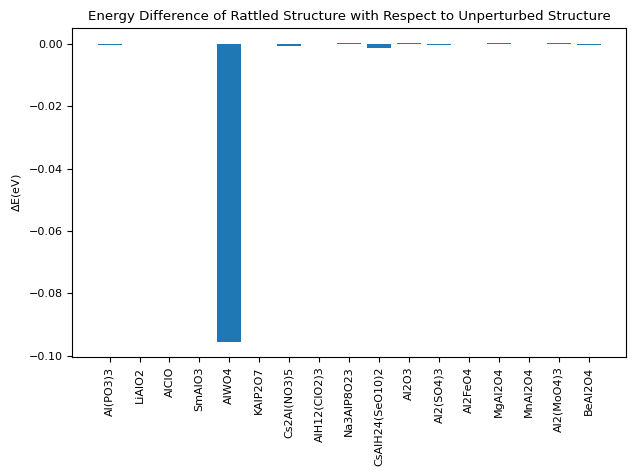

In [43]:
fig, ax = plt.subplots()
bars = ax.bar(compounds, delta_e)  # Assuming you have these lists already

# Add labels on top of each bar
ax.set_title("Energy Difference of Rattled Structure with Respect to Unperturbed Structure")
ax.set_ylabel("$\Delta$E(eV)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"../figures/{MODEL}_energy_difference_plot_{supercell_size}A.png", dpi=300, bbox_inches='tight')

plt.show()